In [1]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn import datasets
from matplotlib import pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
import sklearn
from sklearn.metrics import pairwise_distances_argmin_min

In [2]:
secrets_file = open("secrets.txt","r")

In [3]:
string = secrets_file.read()

In [4]:
string

'clientid:30ba48f11c4347f0aa53053cf58e318a\nclientsecret:74c98bc24a4c41fa9f0d89b6f86d216b'

In [5]:
string.split('\n')

['clientid:30ba48f11c4347f0aa53053cf58e318a',
 'clientsecret:74c98bc24a4c41fa9f0d89b6f86d216b']

In [6]:
secrets_dict={}
for line in string.split('\n'):
    if len(line) > 0:
        secrets_dict[line.split(':')[0]]=line.split(':')[1]

In [7]:
secrets_dict

{'clientid': '30ba48f11c4347f0aa53053cf58e318a',
 'clientsecret': '74c98bc24a4c41fa9f0d89b6f86d216b'}

In [8]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

#Initialize SpotiPy with user credentials
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id=secrets_dict['clientid'],
                                                           client_secret=secrets_dict['clientsecret']))

In [9]:
#We pick our playlists
fifties_playlist = "37i9dQZF1DWSV3Tk4GO2fq"
sixties_playlist = "3SbE5Sk5MWtNc0GRTU0X6d"
seventies_playlist = "37i9dQZF1DX1Hya1sRqqxI"
eighties_playlist = "37i9dQZF1DXb57FjYWz00c"
nineties_playlist = "37i9dQZF1DXbTxeAdrVG2l"
twenties_playlist = "37i9dQZF1DX4o1oenSJRJd"
twenty_tens_playlist = "37i9dQZF1DX5Ejj0EkURtP"
twenty_twenties_playlist = "4vSTV61efRmetmaoz95Vet"

In [10]:
#code to pass the 1050 limit for the tracks got from the api

def get_all_tracks(playlist):
    results = sp.user_playlist_tracks("spotify", playlist)
    tracks = results['items']
    for oset in range(1050,results['total'],1050):
        results = sp.user_playlist_tracks("spotify", playlist, offset=oset)
        tracks += results['items']
    return tracks

all_tracks_50s = get_all_tracks(fifties_playlist)
all_tracks_60s = get_all_tracks(sixties_playlist)
all_tracks_70s = get_all_tracks(seventies_playlist)
all_tracks_80s = get_all_tracks(eighties_playlist)
all_tracks_90s = get_all_tracks(nineties_playlist)
all_tracks_2000s = get_all_tracks(twenties_playlist)
all_tracks_2010s = get_all_tracks(twenty_tens_playlist)
all_tracks_2020s = get_all_tracks(twenty_twenties_playlist)

In [11]:
# Getting all the artists
def get_artists_from_playlist(playlist_id, tracks):
    tracks_from_playlist = tracks
    artists = []
    for track in tracks_from_playlist:
        artist_info = track['track']['artists'][0]
        artists.append(artist_info['name'])
    return artists


all_artists_50s = get_artists_from_playlist(fifties_playlist,all_tracks_50s)
all_artists_60s = get_artists_from_playlist(sixties_playlist,all_tracks_60s)
all_artists_70s = get_artists_from_playlist(seventies_playlist,all_tracks_70s)
all_artists_80s = get_artists_from_playlist(eighties_playlist,all_tracks_80s)
all_artists_90s = get_artists_from_playlist(nineties_playlist,all_tracks_90s)
all_artists_2000s = get_artists_from_playlist(twenties_playlist,all_tracks_2000s)
all_artists_2010s = get_artists_from_playlist(twenty_tens_playlist,all_tracks_2010s)
all_artists_2020s = get_artists_from_playlist(twenty_twenties_playlist,all_tracks_2020s)



In [12]:
#get song names & track ids
def get_song_names(tracks):
    song_actual_names = [track['track']['name'] for track in tracks]
    track_ids = [track['track']['id'] for track in tracks]
    return song_actual_names,track_ids

all_song_names_50s,id_track_50s = get_song_names(all_tracks_50s)
all_song_names_60s,id_track_60s = get_song_names(all_tracks_60s)
all_song_names_70s,id_track_70s = get_song_names(all_tracks_70s)
all_song_names_80s,id_track_80s = get_song_names(all_tracks_80s)
all_song_names_90s,id_track_90s = get_song_names(all_tracks_90s)
all_song_names_2000s,id_track_2000s = get_song_names(all_tracks_2000s)
all_song_names_2010s,id_track_2010s = get_song_names(all_tracks_2010s)
all_song_names_2020s,id_track_2020s = get_song_names(all_tracks_2020s)

In [13]:
#get all genres and popularity

def get_pop_and_genre(tracks):
    genre = []
    popularity = []
    for elem in tracks:
        artist01 = sp.artist(elem['track']["album"]["artists"][0]["external_urls"]["spotify"])
        genre.append(artist01["genres"][0] if artist01["genres"] else "genreless")
        popularity.append(artist01["popularity"])
    return genre,popularity

genre_50s,popularity_50s = get_pop_and_genre(all_tracks_50s)
genre_60s,popularity_60s = get_pop_and_genre(all_tracks_60s)
genre_70s,popularity_70s = get_pop_and_genre(all_tracks_70s)
genre_80s,popularity_80s = get_pop_and_genre(all_tracks_80s)
genre_90s,popularity_90s = get_pop_and_genre(all_tracks_90s)
genre_2000s,popularity_2000s = get_pop_and_genre(all_tracks_2000s)
genre_2010s,popularity_2010s = get_pop_and_genre(all_tracks_2010s)
genre_2020s,popularity_2020s = get_pop_and_genre(all_tracks_2020s)

In [14]:
#gathering main features and turning them into a dataframe
def main_features_to_df(track_ids):
    the_list = []
    for i in track_ids:
        the_list.append(sp.audio_features(i))
    converted = [i for elem in the_list for i in elem]
    df = pd.json_normalize(converted)
    return df

df_50s = main_features_to_df(id_track_50s)
df_60s = main_features_to_df(id_track_60s)
df_70s = main_features_to_df(id_track_70s)
df_80s = main_features_to_df(id_track_80s)
df_90s = main_features_to_df(id_track_90s)
df_2000s = main_features_to_df(id_track_2000s)
df_2010s = main_features_to_df(id_track_2010s)
df_2020s = main_features_to_df(id_track_2020s)

In [15]:
# adding previous single gathered features to the current df
def add_features_to_df(song_actual_names,artist_list,genre,popularity,features_df):
    
    df_song_name = pd.DataFrame(song_actual_names, columns = ["song_name"])
    df_artists = pd.DataFrame(artist_list,columns = ["artists"])
    df_genre = pd.DataFrame(genre,columns = ["genre"])
    df_popularity = pd.DataFrame(popularity,columns = ["popularity"])
    final_boss_df = pd.concat([features_df, df_song_name,df_artists,df_genre,df_popularity], axis=1)
    
    return final_boss_df

final_df_50s = add_features_to_df(all_song_names_50s,all_artists_50s,genre_50s,popularity_50s,df_50s)
final_df_60s = add_features_to_df(all_song_names_60s,all_artists_60s,genre_60s,popularity_60s,df_60s)
final_df_70s = add_features_to_df(all_song_names_70s,all_artists_70s,genre_70s,popularity_70s,df_70s)
final_df_80s = add_features_to_df(all_song_names_80s,all_artists_80s,genre_80s,popularity_80s,df_80s)
final_df_90s = add_features_to_df(all_song_names_90s,all_artists_90s,genre_90s,popularity_90s,df_90s)
final_df_2000s = add_features_to_df(all_song_names_2000s,all_artists_2000s,genre_2000s,popularity_2000s,df_2000s)
final_df_2010s = add_features_to_df(all_song_names_2010s,all_artists_2010s,genre_2010s,popularity_2010s,df_2010s)
final_df_2020s = add_features_to_df(all_song_names_2020s,all_artists_2020s,genre_2020s,popularity_2020s,df_2020s)

In [16]:
#Treating the dataframe:
scaler = StandardScaler()
def scaling_df(current_df):
    df_to_scale = current_df[['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo','popularity']]
    scaled_df02 = scaler.fit_transform(df_to_scale)
    scaled_df01 = pd.DataFrame(scaled_df02)
    scaled_df = scaled_df01.copy()
    scaled_df.columns = df_to_scale.columns
    scaled_df["song_name"] = current_df["song_name"]
    scaled_df["artists"] = current_df["artists"]
    scaled_df["genre"] = current_df["genre"]
    scaled_df
    return scaled_df01,scaled_df

df_to_scale_50s,scaled_df_50s = scaling_df(final_df_50s)
df_to_scale_60s,scaled_df_60s = scaling_df(final_df_60s)
df_to_scale_70s,scaled_df_70s = scaling_df(final_df_70s)
df_to_scale_80s,scaled_df_80s = scaling_df(final_df_80s)
df_to_scale_90s,scaled_df_90s = scaling_df(final_df_90s)
df_to_scale_2000s,scaled_df_2000s = scaling_df(final_df_2000s)
df_to_scale_2010s,scaled_df_2010s = scaling_df(final_df_2010s)
df_to_scale_2020s,scaled_df_2020s = scaling_df(final_df_2020s)

In [17]:
scaled_complete_frames = [scaled_df_50s,scaled_df_60s,scaled_df_70s,scaled_df_80s,scaled_df_90s,scaled_df_2000s,scaled_df_2010s,scaled_df_2020s]

all_frames = pd.concat(scaled_complete_frames)
all_frames.head()

danceability    energy       key  loudness     mode  speechiness  \
0      0.602031  0.052400  1.490470 -0.238877  0.51558     1.505372   
1      0.310364 -0.821901 -1.176375 -0.338655  0.51558    -0.507625   
2     -2.546477 -0.632008 -0.583743 -0.015596  0.51558    -0.676105   
3     -0.026175  0.895053 -0.287427  1.251583  0.51558    -0.271317   
4     -0.616988 -1.067180 -0.880059 -1.552620  0.51558    -0.284445   

   acousticness  instrumentalness  liveness   valence     tempo  popularity  \
0      0.825760         -0.181090 -0.386575  1.211074 -1.363127    1.708527   
1     -1.174755         -0.181065 -0.613190 -0.149747  0.159780    1.885760   
2      1.007625         -0.181134 -0.208958 -1.303240  1.425887   -0.063804   
3      0.485346         -0.181155 -0.276330  0.615479 -0.953866    0.467895   
4     -0.465947         -0.181155 -0.527444 -0.850890 -0.749206    0.999595   

                                      song_name          artists  \
0                                  All Shook Up    Elvis Presley   
1  I've Got You Under My Skin - Remastered 1998    Frank Sinatra   
2                       Smoke Gets In Your Eyes     The Platters   
3                       What'd I Say, Pt. 1 & 2      Ray Charles   
4                    Dream A Little Dream Of Me  Louis Armstrong   

             genre  
0    rock-and-roll  
1  adult standards  
2  adult standards  
3  adult standards  
4  adult standards

In [18]:
scaled_numerical_frames = [df_to_scale_50s,df_to_scale_60s,df_to_scale_70s,df_to_scale_80s,df_to_scale_90s,df_to_scale_2000s,df_to_scale_2010s,df_to_scale_2020s]
Numerical_all_frames = pd.concat(scaled_numerical_frames)

In [19]:
Numerical_all_frames

0         1         2         3         4         5         6   \
0   0.602031  0.052400  1.490470 -0.238877  0.515580  1.505372  0.825760   
1   0.310364 -0.821901 -1.176375 -0.338655  0.515580 -0.507625 -1.174755   
2  -2.546477 -0.632008 -0.583743 -0.015596  0.515580 -0.676105  1.007625   
3  -0.026175  0.895053 -0.287427  1.251583  0.515580 -0.271317  0.485346   
4  -0.616988 -1.067180 -0.880059 -1.552620  0.515580 -0.284445 -0.465947   
..       ...       ...       ...       ...       ...       ...       ...   
95 -0.540882  0.755491 -0.772596  0.416669  0.733799 -0.515211 -0.285415   
96 -2.353737 -0.057678  0.532465 -0.048435 -1.362770 -0.369402 -0.098087   
97  0.068124 -0.675435  1.054489 -0.081384 -1.362770 -0.045257  0.435998   
98  0.592152 -0.650221 -1.294620 -1.160100  0.733799  0.451616 -0.050259   
99  0.422197  1.417374 -1.033608  0.922362 -1.362770  1.416201 -0.998298   

          7         8         9         10        11  
0  -0.181090 -0.386575  1.211074 -1.363127  1.708527  
1  -0.181065 -0.613190 -0.149747  0.159780  1.885760  
2  -0.181134 -0.208958 -1.303240  1.425887 -0.063804  
3  -0.181155 -0.276330  0.615479 -0.953866  0.467895  
4  -0.181155 -0.527444 -0.850890 -0.749206  0.999595  
..       ...       ...       ...       ...       ...  
95 -0.158365  2.076740 -0.293176  1.066327  0.510610  
96 -0.160345  0.205009 -1.215403  1.976017 -2.049971  
97 -0.160345 -0.455601 -0.059309  0.783020  0.510610  
98 -0.157984 -0.531825  0.064243  0.362060  1.414344  
99 -0.160345 -1.026436  0.170144 -1.258874 -0.694369  

[799 rows x 12 columns]

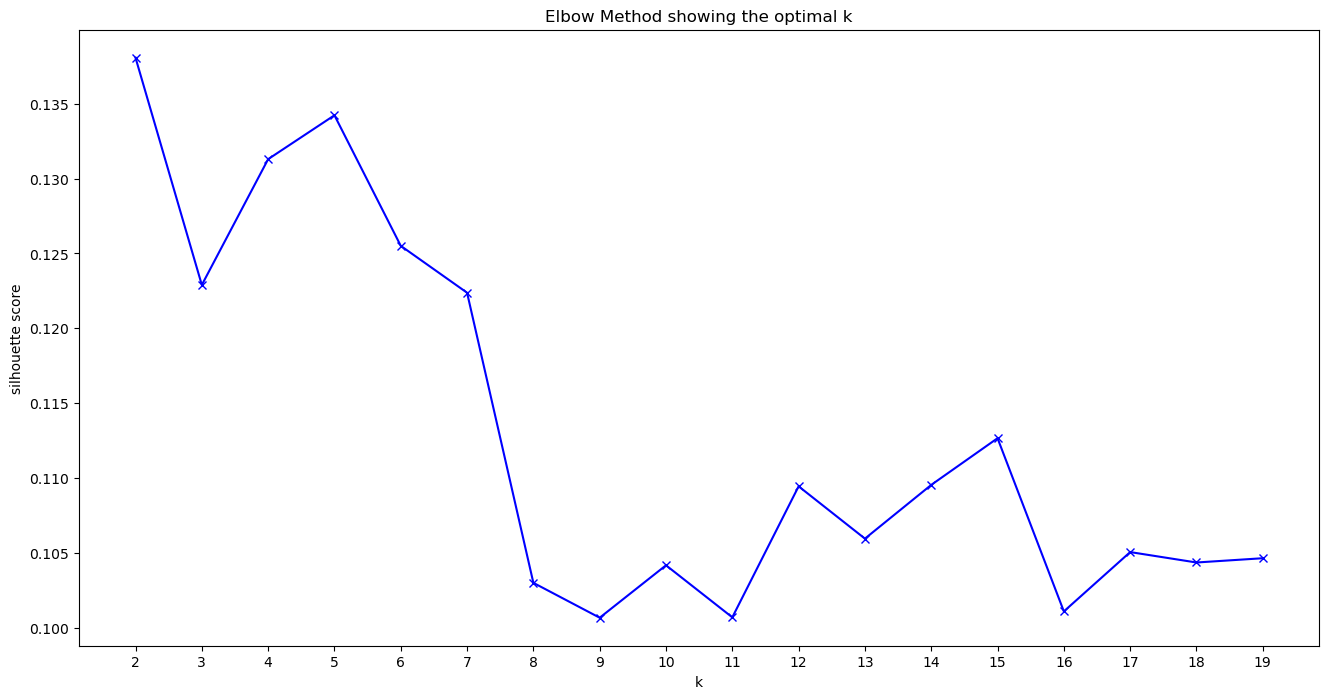

In [20]:
#applying inertia to see how many clusters is a good number to apply

K = range(2, 20)

silhouette = []

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(Numerical_all_frames)
    silhouette.append(silhouette_score(Numerical_all_frames, kmeans.predict(Numerical_all_frames)))


plt.figure(figsize=(16,8))
plt.plot(K, silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Elbow Method showing the optimal k')
plt.show()

In [21]:
#applying the clustering

kmeans = KMeans(n_clusters=7, random_state=42)
kmeans.fit(Numerical_all_frames)

KMeans(n_clusters=7, random_state=42)

In [22]:
# Predicting / assigning the clusters:
clusters = kmeans.predict(Numerical_all_frames)
clusters

array([5, 2, 3, 2, 0, 2, 5, 2, 2, 4, 4, 0, 4, 2, 2, 0, 5, 0, 0, 0, 2, 2,
       0, 0, 2, 2, 2, 0, 4, 2, 6, 5, 0, 0, 5, 2, 0, 4, 5, 4, 6, 0, 0, 4,
       2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 0, 0, 4, 4, 0, 5, 2, 5, 0, 4, 2, 2,
       0, 2, 3, 2, 4, 2, 2, 6, 0, 6, 2, 6, 0, 4, 6, 0, 0, 4, 3, 5, 0, 1,
       6, 2, 1, 0, 6, 3, 2, 0, 4, 3, 4, 0, 3, 6, 0, 0, 5, 2, 4, 3, 3, 4,
       5, 4, 6, 4, 5, 0, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 4, 6, 2, 0, 2, 6,
       0, 6, 2, 6, 3, 0, 5, 2, 2, 2, 2, 0, 2, 0, 4, 0, 4, 6, 6, 3, 2, 0,
       1, 3, 2, 2, 4, 0, 2, 2, 0, 3, 0, 4, 0, 2, 6, 0, 2, 5, 2, 4, 4, 4,
       2, 2, 1, 0, 2, 3, 2, 3, 5, 2, 2, 6, 4, 2, 3, 2, 2, 0, 4, 4, 6, 4,
       2, 0, 2, 4, 2, 3, 0, 2, 2, 4, 2, 2, 3, 0, 2, 4, 6, 2, 2, 4, 3, 2,
       2, 0, 2, 2, 5, 6, 2, 0, 4, 3, 2, 3, 5, 2, 3, 0, 2, 0, 2, 2, 2, 0,
       1, 0, 6, 2, 4, 4, 0, 4, 2, 2, 2, 2, 0, 4, 3, 2, 0, 4, 4, 6, 2, 2,
       4, 3, 1, 2, 3, 6, 0, 3, 0, 0, 2, 1, 4, 6, 3, 0, 0, 3, 0, 0, 6, 2,
       4, 2, 2, 1, 5, 6, 2, 1, 4, 5, 2, 4, 2, 4, 4,

In [23]:
#assigning the clusters to the main final df
all_frames["clusters"] = clusters

In [24]:
# Check the size of the clusters
pd.Series(clusters).value_counts().sort_index()

0    157
1     21
2    236
3    103
4    141
5     61
6     80
dtype: int64

In [25]:
all_frames.groupby(['clusters','genre'], as_index=False).count().sort_values(['clusters', 'key'], ascending=[True, False])[['genre', 'clusters', 'key']].reset_index(drop=True).groupby(["clusters"]).head(3)


genre  clusters  key
0       adult standards         0   38
1                   pop         0   16
2            album rock         0   12
46      adult standards         1    2
47    alternative metal         1    2
48     alternative rock         1    2
63      adult standards         2   39
64            dance pop         2   34
65           album rock         2   12
136          album rock         3   12
137           dance pop         3    8
138   alternative metal         3    7
179           dance pop         4   22
180     adult standards         4   12
181                 pop         4    9
235     adult standards         5    7
236           dance pop         5    5
237  east coast hip hop         5    5
265     adult standards         6   10
266           dance pop         6    9
267          album rock         6    4

In [26]:
all_frames = all_frames.reset_index(drop=True)

In [27]:
all_frames

danceability    energy       key  loudness      mode  speechiness  \
0        0.602031  0.052400  1.490470 -0.238877  0.515580     1.505372   
1        0.310364 -0.821901 -1.176375 -0.338655  0.515580    -0.507625   
2       -2.546477 -0.632008 -0.583743 -0.015596  0.515580    -0.676105   
3       -0.026175  0.895053 -0.287427  1.251583  0.515580    -0.271317   
4       -0.616988 -1.067180 -0.880059 -1.552620  0.515580    -0.284445   
..            ...       ...       ...       ...       ...          ...   
794     -0.540882  0.755491 -0.772596  0.416669  0.733799    -0.515211   
795     -2.353737 -0.057678  0.532465 -0.048435 -1.362770    -0.369402   
796      0.068124 -0.675435  1.054489 -0.081384 -1.362770    -0.045257   
797      0.592152 -0.650221 -1.294620 -1.160100  0.733799     0.451616   
798      0.422197  1.417374 -1.033608  0.922362 -1.362770     1.416201   

     acousticness  instrumentalness  liveness   valence     tempo  popularity  \
0        0.825760         -0.181090 -0.386575  1.211074 -1.363127    1.708527   
1       -1.174755         -0.181065 -0.613190 -0.149747  0.159780    1.885760   
2        1.007625         -0.181134 -0.208958 -1.303240  1.425887   -0.063804   
3        0.485346         -0.181155 -0.276330  0.615479 -0.953866    0.467895   
4       -0.465947         -0.181155 -0.527444 -0.850890 -0.749206    0.999595   
..            ...               ...       ...       ...       ...         ...   
794     -0.285415         -0.158365  2.076740 -0.293176  1.066327    0.510610   
795     -0.098087         -0.160345  0.205009 -1.215403  1.976017   -2.049971   
796      0.435998         -0.160345 -0.455601 -0.059309  0.783020    0.510610   
797     -0.050259         -0.157984 -0.531825  0.064243  0.362060    1.414344   
798     -0.998298         -0.160345 -1.026436  0.170144 -1.258874   -0.694369   

                                        song_name          artists  \
0                                    All Shook Up    Elvis Presley   
1    I've Got You Under My Skin - Remastered 1998    Frank Sinatra   
2                         Smoke Gets In Your Eyes     The Platters   
3                         What'd I Say, Pt. 1 & 2      Ray Charles   
4                      Dream A Little Dream Of Me  Louis Armstrong   
..                                            ...              ...   
794                                         Ghost    Justin Bieber   
795                                     Boyfriend     Dove Cameron   
796                                         Yummy    Justin Bieber   
797          Laugh Now Cry Later (feat. Lil Durk)            Drake   
798                             THATS WHAT I WANT        Lil Nas X   

                genre  clusters  
0       rock-and-roll         5  
1     adult standards         2  
2     adult standards         3  
3     adult standards         2  
4     adult standards         0  
..                ...       ...  
794      canadian pop         6  
795               pop         3  
796      canadian pop         4  
797  canadian hip hop         2  
798    lgbtq+ hip hop         4  

[799 rows x 16 columns]

In [28]:
from sklearn.preprocessing import StandardScaler
X_prep = StandardScaler().fit_transform(Numerical_all_frames)
X_prep

array([[ 0.60203059,  0.05240032,  1.49047015, ...,  1.21107371,
        -1.3631266 ,  1.70852713],
       [ 0.3103636 , -0.82190102, -1.17637505, ..., -0.1497468 ,
         0.15978041,  1.88576023],
       [-2.54647722, -0.63200752, -0.58374278, ..., -1.30324009,
         1.42588665, -0.06380392],
       ...,
       [ 0.06812369, -0.67543511,  1.05448888, ..., -0.05930937,
         0.78302032,  0.51060992],
       [ 0.59215208, -0.65022055, -1.29462002, ...,  0.06424263,
         0.36206022,  1.4143443 ],
       [ 0.42219693,  1.41737364, -1.03360792, ...,  0.17014434,
        -1.25887404, -0.69436925]])

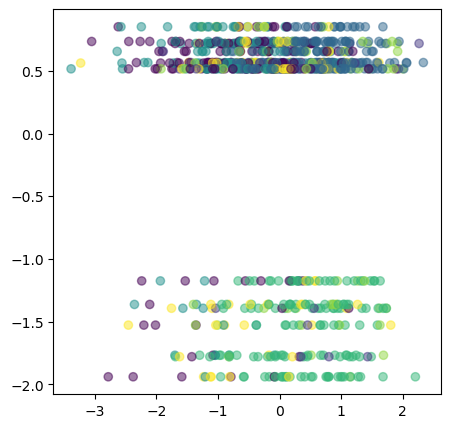

In [29]:
plt.figure(figsize=(5, 5))
plt.scatter(X_prep[:, 0], X_prep[:, 4], c=clusters,alpha=0.5)
plt.show()

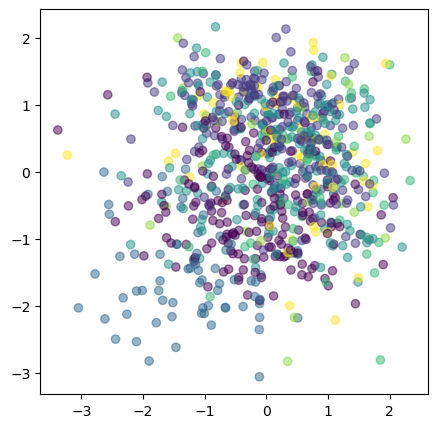

In [30]:
from sklearn import cluster
agglomerative = cluster.AgglomerativeClustering(n_clusters=7,linkage='ward')
pred = agglomerative.fit_predict(X_prep)
plt.figure(figsize=(5, 5))
plt.scatter(X_prep[:, 0], X_prep[:, 1], c=pred,alpha=0.5)
plt.show()

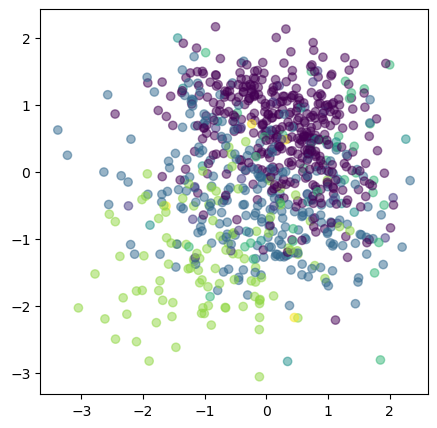

In [31]:
#complete linkage penalizes heavily outliers
agglomerative = cluster.AgglomerativeClustering(n_clusters=7,linkage='complete')
pred = agglomerative.fit_predict(X_prep)
plt.figure(figsize=(5, 5))
plt.scatter(X_prep[:, 0], X_prep[:, 1], c=pred,alpha=0.5)
plt.show()

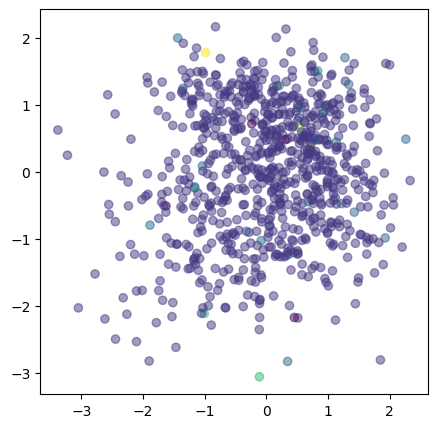

In [32]:
# different algorithms are good for different applications
agglomerative = cluster.AgglomerativeClustering(n_clusters=7,linkage='average')
pred = agglomerative.fit_predict(X_prep)
plt.figure(figsize=(5, 5))
plt.scatter(X_prep[:, 0], X_prep[:, 1], c=pred,alpha=0.5)
plt.show()

In [33]:
#getting song and recomending song
def recomend_song():
    song_name = input("Choose a song: ")
    results = sp.search(q=f'track:{song_name}', limit=1)
    track_id = results['tracks']['items'][0]['id'] if results['tracks']['items'] else None
    while not track_id:
        return recomend_song()
    # get song features with the obtained id
    audio_features = sp.audio_features(track_id)
    #get song popularity and genre
    song_pop_genre = sp.artist(results['tracks']["items"][0]["album"]["artists"][0]["external_urls"]["spotify"])
    the_genre = song_pop_genre["genres"][0] if song_pop_genre["genres"] else "generless"
    the_pop = song_pop_genre["popularity"]
    #create the df
    df_uni_song = pd.DataFrame(audio_features)
    df_uni_song["popularity"] = the_pop
    #merge the datas
    new_features = df_uni_song[['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo','popularity']]
    df_uni_song["genre"] = the_genre
    #scale features
    #scaler = StandardScaler()
    scaled_x = scaler.transform(new_features)
    # predict cluster
    cluster = kmeans.predict(scaled_x)
    # filter dataset to predicted cluster
    filtered_df = all_frames[all_frames['clusters'] == cluster[0]][new_features.columns]
    # get closest song from filtered dataset
    closest, _ = pairwise_distances_argmin_min(scaled_x, filtered_df)
    # return it in a readable way
    print('\n [RECOMMENDED SONG]')
    return ' - '.join([all_frames.loc[closest]['song_name'].values[0], all_frames.loc[closest]['artists'].values[0]])

In [34]:
recomend_song()

Choose a song: hi

 [RECOMMENDED SONG]


'Cheek To Cheek - Ella Fitzgerald'